In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# REFERENCED FROM: https://github.com/DimaKrotov/Biological_Learning
# To draw a heatmap of the weights a helper function is created

def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw() 

In [4]:
# Initialize variables required for the algorithm

learning_rate = 2e-2    # initial learning rate
Kx = 10
Ky = 10
n_hidden = Kx*Ky        # number of hidden units that are displayed in Ky by Kx array
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 200          # number of epochs
batch_size = 100        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates
anti_hebbian_learning_strength = 0.4    # Strength of the anti-hebbian learning
lebesgue_norm = 2.0                     # Lebesgue norm of the weights
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2

In [5]:
# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Define function that performs the unsupervised learning and returns weights
# that correspond to feature detectors.
# Uses cuda if available.
def get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                             anti_hebbian_learning_strength, lebesgue_norm, rank):
    print("Starting unsupervised bio-plausible training")
    
    num_samples = data.shape[0]   # Number of samples/images.
    num_features = data.shape[1]  # Number of pixels for each sample/image.
    
    # Initialize weights to be values drawn from gaussian distribution.
    synapses = np.random.normal(mu, sigma, (n_hidden, num_features)).astype(np.float32)
    weights = torch.from_numpy(synapses).to(device)

    # The external loop runs over epochs
    for epoch in range(n_epochs):
        eps = learning_rate * (1 - epoch / n_epochs)
        #print(f'epoch learning rate: {eps}')

        # Scramble the images and values. So that when making a
        # mini batch, random values/images will be chosen on each iteration.
        random_permutation_samples = np.random.permutation(num_samples)
        shuffled_epoch_data = data[random_permutation_samples,:]

        # Internal loop runs over minibatches    
        for i in range(num_samples // batch_size):        
            # For every minibatch the overlap with the data (tot_input) is 
            # calculated for each data point and each hidden unit.
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
            mini_batch = torch.from_numpy(mini_batch).to(device)           
            mini_batch = torch.transpose(mini_batch, 0, 1)

            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
            # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
            tot_input_torch = torch.mm(W, mini_batch)

            # The sorted strengths of the activations are stored in y. 
            # The variable yl stores the activations of the post synaptic cells - 
            # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
            y_torch = torch.argsort(tot_input_torch, dim=0)            
            yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
            yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength

            # The variable ds is the right hand side of Eq 3        
            xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
            xx_torch = xx_torch.unsqueeze(1)                    
            xx_torch = xx_torch.repeat(1, num_features)
            ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)

            # Update weights
            # The weights are updated after each minibatch in a way so that the largest update 
            # is equal to the learning rate eps at that epoch.        
            nc_torch = torch.max(torch.abs(ds_torch))
            if nc_torch < precision: 
                nc_torch = precision            
            weights += eps*(ds_torch/nc_torch)

            #if (i+1) % 100 == 0:
            #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')

        print (f'Epoch [{epoch+1}/{n_epochs}]')
        
    print("Completed unsupervised bio-plausible training")
    return weights.cpu().numpy()


In [8]:
# LOAD AND PREPARE DATA

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")

Nc=10 # number of classes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data = M
print(f'Number of samples: {data.shape[0]}')
print(f'Number of features: {data.shape[1]}')

Loading MNIST...
Done loading MNIST
Number of samples: 60000
Number of features: 784


In [9]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Calculates weights for data and provided number of hidden units (given other configuration)
weights = get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                   anti_hebbian_learning_strength, lebesgue_norm, rank)


Starting unsupervised bio-plausible training
Epoch [1/200]
Epoch [2/200]
Epoch [3/200]
Epoch [4/200]
Epoch [5/200]
Epoch [6/200]
Epoch [7/200]
Epoch [8/200]
Epoch [9/200]
Epoch [10/200]
Epoch [11/200]
Epoch [12/200]
Epoch [13/200]
Epoch [14/200]
Epoch [15/200]
Epoch [16/200]
Epoch [17/200]
Epoch [18/200]
Epoch [19/200]
Epoch [20/200]
Epoch [21/200]
Epoch [22/200]
Epoch [23/200]
Epoch [24/200]
Epoch [25/200]
Epoch [26/200]
Epoch [27/200]
Epoch [28/200]
Epoch [29/200]
Epoch [30/200]
Epoch [31/200]
Epoch [32/200]
Epoch [33/200]
Epoch [34/200]
Epoch [35/200]
Epoch [36/200]
Epoch [37/200]
Epoch [38/200]
Epoch [39/200]
Epoch [40/200]
Epoch [41/200]
Epoch [42/200]
Epoch [43/200]
Epoch [44/200]
Epoch [45/200]
Epoch [46/200]
Epoch [47/200]
Epoch [48/200]
Epoch [49/200]
Epoch [50/200]
Epoch [51/200]
Epoch [52/200]
Epoch [53/200]
Epoch [54/200]
Epoch [55/200]
Epoch [56/200]
Epoch [57/200]
Epoch [58/200]
Epoch [59/200]
Epoch [60/200]
Epoch [61/200]
Epoch [62/200]
Epoch [63/200]
Epoch [64/200]
Epoc

<IPython.core.display.Javascript object>


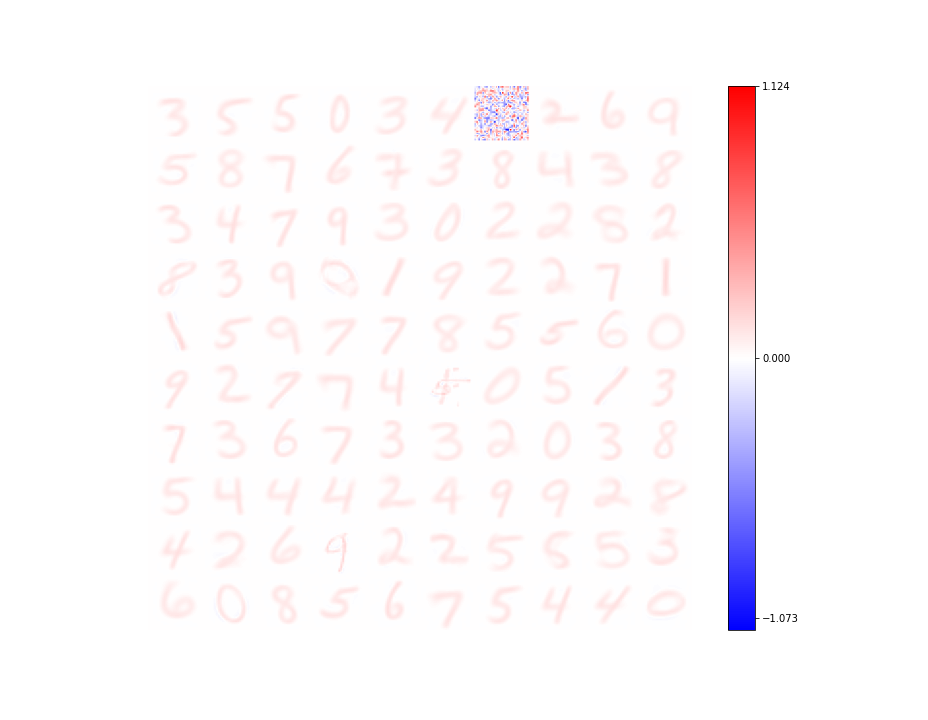

Fin


In [10]:
# Draw weights/feature detectors generated by unsupervised bio algo

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights, Kx, Ky)
print("Fin")

In [ ]:
# USE THIS BLOCK FOR DEBUGGING PURPOSES ONLY

# Contains data loading and whole bio learning in one block of code.
# Plots the feature detectors at the end of training.

# LOAD AND PREPARE DATA

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")

Nc=10 # output nodes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data = M
num_samples = data.shape[0]   # 60000 training and validation examples. Number of samples
num_features = data.shape[1]  # number of pixels for each image. 28x28. Also: num_samples, num_pixels..

# ------------------------------------------------------------------------------------------------------------

# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Initialize weights to be values drawn from gaussian distribution.
synapses = np.random.normal(mu, sigma, (n_hidden, N)).astype(np.float32)
weights = torch.from_numpy(synapses).to(device)

# The external loop runs over epochs
for epoch in range(n_epochs):
    eps = learning_rate * (1 - epoch / n_epochs)
    #print(f'epoch learning rate: {eps}')
    
    # Scramble the images and values. So that when making a
    # mini batch, random values/images will be chosen on each iteration.
    random_permutation_samples = np.random.permutation(num_samples)
    shuffled_epoch_data = data[random_permutation_samples,:]
    
    # Internal loop runs over minibatches    
    for i in range(num_samples // batch_size):        
        # For every minibatch the overlap with the data (tot_input) is 
        # calculated for each data point and each hidden unit.
        mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
        mini_batch = torch.from_numpy(mini_batch).to(device)           
        mini_batch = torch.transpose(mini_batch, 0, 1)
        
        sign = torch.sign(weights)            
        W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
        # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
        tot_input_torch = torch.mm(W, mini_batch)
                
        # The sorted strengths of the activations are stored in y. 
        # The variable yl stores the activations of the post synaptic cells - 
        # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
        y_torch = torch.argsort(tot_input_torch, dim=0)            
        yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
        yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
        yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength
        
        # The variable ds is the right hand side of Eq 3        
        xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
        xx_torch = xx_torch.unsqueeze(1)                    
        xx_torch = xx_torch.repeat(1, num_features)
        ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)
        
        # Update weights
        # The weights are updated after each minibatch in a way so that the largest update 
        # is equal to the learning rate eps at that epoch.        
        nc_torch = torch.max(torch.abs(ds_torch))
        if nc_torch < precision: 
            nc_torch = precision            
        weights += eps*(ds_torch/nc_torch)
        
        #if (i+1) % 100 == 0:
        #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')
        
    print (f'Epoch [{epoch+1}/{n_epochs}]')
    #draw_weights(weights.numpy(), Kx, Ky)

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights.cpu().numpy(), Kx, Ky)
print("Fin")